In [1]:
import numpy as np  
import numpy.polynomial.legendre as npl
import sympy as sp
import matplotlib.pyplot as plt
from scipy.special import legendre
from scipy.interpolate import lagrange
import math 

In [2]:
def Transformation(nodes, weight,a,b):
    nodes=(b-a)/2*nodes+(a+b)/2
    weight=(b-a)/2 *weight
    return (nodes,weight)

In [3]:
def chop(lista):
    for i in range(len(lista)):
        if(abs(lista[i])<(10**(-10))):
            lista[i]=0
    return lista

In [4]:
class Cuadrature:
    def __init__(self,nodes=None,weight=None):
        if(list(nodes)!=None):
                self.nodes=nodes
        if(list(weight)!=None):
                self.weight=weight
        
    def getNodes(self):
        return self.nodes
    def getWeight(self):
        return self.weight
    def getNumPoints(self):
        return len(self.nodes)
    
    def Integrate(self,f):
        return self.Integrate_List(f(np.array(self.nodes)))
    
    def Integrate_List(self,lista):
        if (len(lista)==len(self.weight)):
            return np.array(lista).dot(np.array(self.weight))
        else:
            raise Exception("No has metido correctamente la lista")

In [5]:
class Lobato(Cuadrature):
    def __init__(self, num_points,a,b):
        aux=[-1,*sorted(list(legendre(num_points).deriv().r)),1]
        Cuadrature.__init__(self, nodes=np.array(aux), weight=np.array(2/(num_points*(num_points+1)*(legendre(num_points)(aux))**2)))
        self.nodes,self.weight=Transformation(self.nodes, self.weight, a, b)
    def __str__(self):
        return "Nodos: %s \nPesos: %s " %(self.nodes,self.weight)

In [6]:
class Legendre(Cuadrature):
    def __init__(self,num_points,a,b):
        Cuadrature.__init__(self,nodes=npl.leggauss(num_points)[0], weight=npl.leggauss(num_points)[1]) 
        self.nodes,self.weight=Transformation(self.nodes, self.weight, a, b)
    def __str__(self):
        return "Nodos: %s \nPesos: %s " %(self.nodes,self.weight)

In [7]:
class Trapecio_Compuesto(Cuadrature): #están considerados los extremos(-1,1)
    def __init__(self,num_points,a,b):
        Cuadrature.__init__(self, nodes=np.array([*np.arange(-1,1,float(2/num_points)).tolist(),1]), weight=np.array([2/(2*num_points),*[2/num_points]*(num_points-1),2/(2*num_points)]))
        self.nodes,self.weight=Transformation(self.nodes, self.weight, a, b)
    def __str__(self):
        return "Nodos: %s \nPesos: %s " %(self.nodes,self.weight)

Hacemos interpolación en vez de continuar con phi

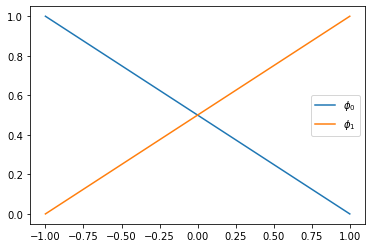

In [8]:
N=1
x = sp.symbols('x')
xvals = chop(Lobato(N,-1,1).getNodes())

phi0=lambda x:lagrange(xvals,[1,0])(x)
difphi0=lambda x: lagrange(xvals,[1,0]).deriv()(x)
                                                                                    
phi1=lambda x:lagrange(xvals,[0,1])(x)
difphi1=lambda x: lagrange(xvals,[0,1]).deriv()(x)

phi=[phi0,phi1]
difphi=[difphi0,difphi1]

xval=np.linspace(-1,1,200)
for i in range(0,len(phi)):
    plt.plot(xval,phi[i](xval),label="$\phi_{0}$".format(i))
plt.legend()

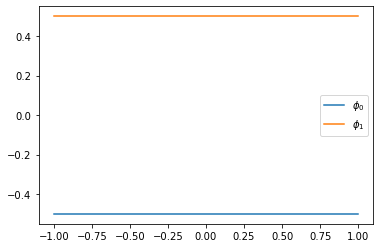

In [10]:
xval=np.linspace(-1,1,200)
for i in range(0,len(phi)):
    plt.plot(xval,difphi[i](xval),label="$\phi_{0}$".format(i))
plt.legend()

In [11]:
def Matriz_Local_bonita(m,p,Nq,num_interval): #p siempre será 4 en nuestra actividad
    
    intervals=np.linspace(-1,1,m+1)
    A=np.zeros((p+1, p+1))
    a=intervals[num_interval-1]
    b=intervals[num_interval]
    xvals2 = chop(Lobato(Nq-1,-1,1).getNodes())
    J=(b-a)/2
    
    for i in range(0,p+1):
        for j in range(0,p+1):
            A[i][j]=Lobato(Nq-1,a,b).Integrate_List((difphi[i](xvals2))/J*(difphi[j](xvals2)/J))
    
    return A

In [12]:
Matriz_Local_bonita(2,1,5,1)

array([[ 1., -1.],
       [-1.,  1.]])

In [13]:
def Vector_Ind_bonita(m,p,Nq,num_interval,f): #p siempre será 4 en nuestra actividad
    
    intervals=np.linspace(-1,1,m+1)
    A=np.zeros(p+1)
    a=intervals[num_interval-1]
    b=intervals[num_interval]
 
    xvals2 = chop(Lobato(Nq-1,-1,1).getNodes())
    xvals3 = chop(Lobato(Nq-1,a,b).getNodes())
    
    for i in range(0,p+1):
            A[i]=Lobato(Nq-1,a,b).Integrate_List(f(xvals3)*phi[i](xvals2))  
        
    return A

In [14]:
f=lambda x: -6*x
Vector_Ind_bonita(3,1,5,3,f)

array([-1.11111111, -1.55555556])

### Al hacer la matriz local la incorporamos dentro de la global y luego al siguiente intervalo.

In [16]:
def Matriz_Global(m,p,Nq,f):#m es nº de intervalos
    
    AG=np.zeros((p*m+1, p*m+1))
    BG=np.zeros(p*m+1)
    for k in range(0,m):
        A=Matriz_Local_bonita(m,p,Nq,k+1)
        B=Vector_Ind_bonita(m,p,Nq,k+1,f)
        for i in range(0,p+1):
            BG[k*p+i]=BG[k*p+i]+B[i]
            for j in range(0,p+1):
                AG[k*p+i][k*p+j] = AG[k*p+i][k*p+j] + A[i][j]
                #print("int",k+1,"k*p+i:",k*p+i," k*p+j:",k*p+j," k,i,j",k,i,j," sol:",AG[k*p+i][k*p+j] )
    return (AG,BG)

In [17]:
def Matriz_A_Global(m,p,Nq,f):#m es nº de intervalos
    
    AG=np.zeros((p*m+1, p*m+1))
    for k in range(0,m):
        A=Matriz_Local_bonita(m,p,Nq,k+1)
        for i in range(0,p+1):
            for j in range(0,p+1):
                AG[k*p+i][k*p+j] = AG[k*p+i][k*p+j] + A[i][j]
                #print("int",k+1,"k*p+i:",k*p+i," k*p+j:",k*p+j," k,i,j",k,i,j," sol:",AG[k*p+i][k*p+j] )
    return AG

In [18]:
def Matriz_B_Global(m,p,Nq,f):#m es nº de intervalos
    
    BG=np.zeros(p*m+1)
    for k in range(0,m):
        B=Vector_Ind_bonita(m,p,Nq,k+1,f)
        for i in range(0,p+1):
            BG[k*p+i]=BG[k*p+i]+B[i]
                 #print("int",k+1,"k*p+i:",k*p+i," k*p+j:",k*p+j," k,i,j",k,i,j," sol:",AG[k*p+i][k*p+j] )
    return BG

In [19]:
f= lambda x:2
Matriz_Global(2,1,5,f)

(array([[ 1., -1.,  0.],
        [-1.,  2., -1.],
        [ 0., -1.,  1.]]), array([1., 2., 1.]))

In [20]:
def Solucion(N_vals, Nq, f, cond1, cond2):
    AG=Matriz_A_Global(N_vals,1,Nq,f) 
    BG=Matriz_B_Global(N_vals,1,Nq,f) 
    
    AG[0][0]=10**30
    BG[0]=cond1*10**30
    AG[len(AG)-1][len(AG)-1]=10**30
    BG[len(BG)-1]=cond2*10**30

    return np.linalg.solve(AG,BG) 

## Ejemplos 1D : $-u''=f$

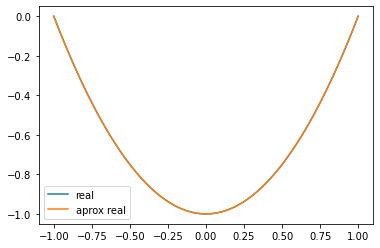

In [21]:
f= lambda x: -2
real = lambda x: x**2-1

N_vals=100 #Num intervalos
Nq=5 #nodos de cuadratura 
cond1=cond2=0
X = Solucion(N_vals, Nq, f, cond1, cond2)

valores=np.linspace(-1,1,len(X))
plt.plot(valores,real(valores),label="real")
plt.plot(np.linspace(-1,1,len(X)),X,label="aprox real")
plt.legend()

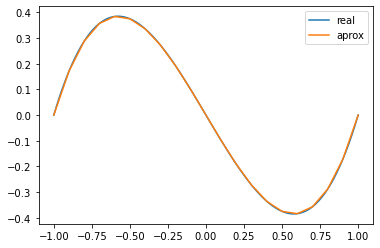

In [22]:
f= lambda x:-6*x
real= lambda x: x*(x+1)*(x-1) 

N_vals=20 #Num intervalos
Nq=20 #nodos de cuadratura 
cond1=cond2=0
X = Solucion(N_vals, Nq, f, cond1, cond2)

valores=np.linspace(-1,1,101)
plt.plot(valores,real(valores),label="real")
plt.plot(np.linspace(-1,1,len(X)),X,label="aprox")
plt.legend()

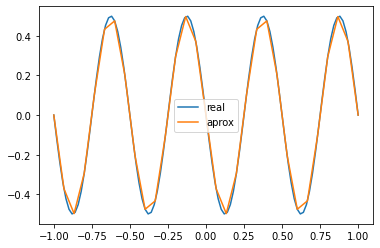

In [23]:
f= lambda x: -16*np.pi**2*np.cos(2*np.pi*x)*np.sin(2*np.pi*x)
real = lambda x: -np.sin(2*np.pi*x)*np.cos(2*np.pi*x)

N_vals=30 #Num intervalos
Nq=7 #nodos de cuadratura 
cond1=cond2=0
X = Solucion(N_vals, Nq, f, cond1, cond2)

valores=np.linspace(-1,1,101)
plt.plot(valores,real(valores),label="real")
plt.plot(np.linspace(-1,1,len(X)),X,label="aprox")
plt.legend()

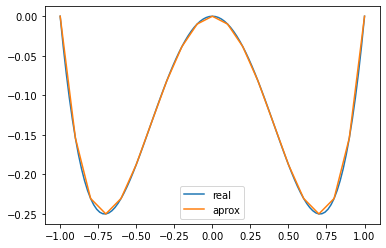

In [24]:
f=lambda x:2-12*x**2
real = lambda x:-x**2*(1 - x**2)

N_vals=20 #Num intervalos
Nq=20 #nodos de cuadratura 
cond1=cond2=0
X = Solucion(N_vals, Nq, f, cond1, cond2)

valores=np.linspace(-1,1,101)
plt.plot(valores,real(valores),label="real")
plt.plot(np.linspace(-1,1,len(X)),X,label="aprox")
plt.legend()

Ejemplos cuyas condiciones de contorno no son 0

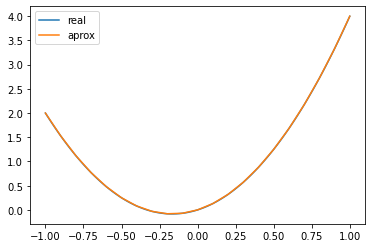

In [25]:
f= lambda x: -6
real = lambda x: 3*x**2+x

N_vals=20 #Num intervalos
Nq=20 #nodos de cuadratura 
cond1=2
cond2=4
X = Solucion(N_vals, Nq, f, cond1, cond2)

valores=np.linspace(-1,1,101)
plt.plot(valores,real(valores),label="real")
plt.plot(np.linspace(-1,1,len(X)),X,label="aprox")
plt.legend()

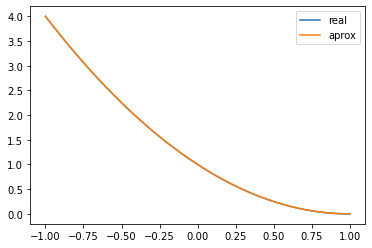

In [26]:
f= lambda x: -2
real = lambda x: (x-1)**2

N_vals=20 #Num intervalos
Nq=20 #nodos de cuadratura 
cond1=4
cond2=0
X = Solucion(N_vals, Nq, f, cond1, cond2)

valores=np.linspace(-1,1,101)
plt.plot(valores,real(valores),label="real")
plt.plot(np.linspace(-1,1,len(X)),X,label="aprox")
plt.legend()

## Dimensión 2

In [27]:
f= lambda x:-2
A,B=Matriz_Global(2,1,5,f)
A

array([[ 1., -1.,  0.],
       [-1.,  2., -1.],
       [ 0., -1.,  1.]])

Para sacar a partir de I los índices I=(i,j)

In [28]:
k=8
i=round(math.modf(k/3)[1])
j=round(math.modf(k/3)[0]*3)
print(i,j)

2 2


In [32]:
def Matriz_Local_SinD(m,p,Nq,num_interval):
    
    intervals=np.linspace(-1,1,m+1)
    A=np.zeros((p+1, p+1))
    a=intervals[num_interval-1]
    b=intervals[num_interval]
    xvals2 = chop(Lobato(Nq-1,-1,1).getNodes())
    
    for i in range(0,p+1):
        for j in range(0,p+1):
            A[i][j]=Lobato(Nq-1,a,b).Integrate_List(phi[i](xvals2)*phi[j](xvals2))
    
    return A

def Matriz_Global_SinD(m,p,Nq,f):#m es nº de intervalos
    
    AG=np.zeros((p*m+1, p*m+1))
    BG=np.zeros(p*m+1)
    for k in range(0,m):
        A=Matriz_Local_SinD(m,p,Nq,k+1)
        B=Vector_Ind_bonita(m,p,Nq,k+1,f)
        for i in range(0,p+1):
            BG[k*p+i]=BG[k*p+i]+B[i]
            for j in range(0,p+1):
                AG[k*p+i][k*p+j] = AG[k*p+i][k*p+j] + A[i][j]
                #print("int",k+1,"k*p+i:",k*p+i," k*p+j:",k*p+j," k,i,j",k,i,j," sol:",AG[k*p+i][k*p+j] )
    return (AG,BG)

In [37]:
def Matriz_Global_2D(m,p,Nq): 
    
    intervals=np.linspace(-1,1,m+1)
    A,B=Matriz_Global(m,p,Nq,f) #las B no sirven de momento
    A1,B1=Matriz_Global_SinD(m,p,Nq,f)
    print("A: ",A)
    print("A1: ",A1)
    A2=np.zeros(((m+1)*(m+1),(m+1)*(m+1)))
    
    for k1 in range(0,(m+1)*(m+1)):
        i1=round(math.modf(k1/3)[1])
        j1=round(math.modf(k1/3)[0]*3)
        #print("k1: ",k1, "i1,j1: ",i1,j1)
        for k2 in range(0,(m+1)*(m+1)):
            i2=round(math.modf(k2/3)[1])
            j2=round(math.modf(k2/3)[0]*3)
            #print("k2: ",k2, "i2,j2: ",i2,j2 )
            A2[k1][k2]=A[i1][j1]*A1[i2][j2]+A1[i1][j1]*A[i2][j2]
            #print(A2)
                        
    return A2

A partir de las globales donde ya tenemos cada punto final y los respectivos índices a partir de esta ecuación creo la matriz global de 2D

$\int_{-1}^{1} d_x(\varphi_i(x)) d_x(\varphi_k(x))dx \int_{-1}^{1} \varphi_j(y)\varphi_l(y))dy +
\int_{-1}^{1} d_y(\varphi_j(y)) d_y(\varphi_l(y))dy \int_{-1}^{1} \varphi_i(x)\varphi_k(x))dx  $

In [38]:
Matriz_Global_2D(2,1,5)

A:  [[ 1. -1.  0.]
 [-1.  2. -1.]
 [ 0. -1.  1.]]
A1:  [[0.33333333 0.16666667 0.        ]
 [0.16666667 0.66666667 0.16666667]
 [0.         0.16666667 0.33333333]]


array([[ 0.66666667, -0.16666667,  0.        , -0.16666667,  1.33333333,
        -0.16666667,  0.        , -0.16666667,  0.66666667],
       [-0.16666667, -0.33333333,  0.        , -0.33333333, -0.33333333,
        -0.33333333,  0.        , -0.33333333, -0.16666667],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [-0.16666667, -0.33333333,  0.        , -0.33333333, -0.33333333,
        -0.33333333,  0.        , -0.33333333, -0.16666667],
       [ 1.33333333, -0.33333333,  0.        , -0.33333333,  2.66666667,
        -0.33333333,  0.        , -0.33333333,  1.33333333],
       [-0.16666667, -0.33333333,  0.        , -0.33333333, -0.33333333,
        -0.33333333,  0.        , -0.33333333, -0.16666667],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [-0.16666667, -0.33333333,  0.        , -0.33333333, -0

Lo de abajo no hay que hacerle caso!!

In [51]:
def Vector_Ind_2D(m,p,Nq,num_interval,f): #p siempre será 4 en nuestra actividad
    
    intervals=np.linspace(-1,1,m+1)
    A=np.zeros((m+1)*(m+1))
    print("len",len(A))
    a=intervals[num_interval-1]
    b=intervals[num_interval]
 
    xvals2 = chop(Lobato(Nq-1,-1,1).getNodes())
    xvals3 = chop(Lobato(Nq-1,a,b).getNodes())
    
    for k in range(0,((m+1)*(m+1))):
        print(k)
        i=round(math.modf(k/(m+1))[1])
        j=round(math.modf(k/(m+1))[0]*(m+1))
        aux=Lobato(Nq-1,a,b).Integrate_List(f(xvals3,xvals3)*phi[i](xvals2))  
        A[k]=Lobato(Nq-1,a,b).Integrate_List(aux*phi[j](xvals2))
            
    return A

In [52]:
f= lambda x,y:x**2+y**2
Vector_Ind_2D(2,1,5,1,f)

len 9
0
1
2


IndexError: list index out of range